<a href="https://colab.research.google.com/github/Beerschtein/Neural_networks/blob/main/Course_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Задания к курсу

**1. Обучите нейронную сеть любой архитектуры, которой не было на курсе, либо нейронную сеть разобранной архитектуры, но на том датасете, которого не было на уроках. Сделайте анализ того, что вам помогло в улучшения работы нейронной сети.**

**2. Сделайте краткий обзор научной работы, посвящённой алгоритму нейронных сетей, не рассматриваемому ранее на курсе. Проведите анализ: чем отличается выбранная архитектура от других? В чём плюсы и минусы данной архитектуры? Какие могут возникнуть трудности при её применении на практике?**

## Проверка устройств для кераса

In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 672780456041568373
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14444920832
locality {
  bus_id: 1
  links {
  }
}
incarnation: 17253422690211448935
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]


### Подготовка библиотек и загрузка данных. В качестве датасета используем Labelled Faces in the Wild Home (LFW) Dataset с сайта https://analyticsindiamag.com/10-face-datasets-to-start-facial-recognition-projects/

In [ ]:
RANDOM_SEED = 42

In [ ]:
import sklearn
from os import path
from sklearn.datasets import fetch_lfw_people
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import sequence
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import categorical_crossentropy
from keras import optimizers

path="/content/drive/MyDrive/NeuralNetwork/Course_project/lfw"

lfw_dataset=sklearn.datasets.fetch_lfw_people(
    data_home=path,
    min_faces_per_person=100,
    download_if_missing=True
)

### Посмотрим на количество и размер входных данных.

In [ ]:
print(lfw_dataset.images.shape)
print(lfw_dataset.data.shape)
print(lfw_dataset.target_names.shape)
print(lfw_dataset.target.shape)

(1140, 62, 47)
(1140, 2914)
(5,)
(1140,)


### Посмотрим, что представляет из себя одно из изображений:

In [ ]:
from PIL import Image
from matplotlib import cm
import numpy as np

image = lfw_dataset.images[1]
PIL_image = Image.fromarray(np.uint8(image)).convert('RGB')

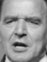

In [ ]:
PIL_image

### Посмотрим на целевую переменную:

In [ ]:
lfw_dataset.target

array([2, 3, 1, ..., 4, 2, 4])

### И на имена людей, изображенных на фотографиях

In [ ]:
names = lfw_dataset.target_names

In [ ]:
names

array(['Colin Powell', 'Donald Rumsfeld', 'George W Bush',
       'Gerhard Schroeder', 'Tony Blair'], dtype='<U17')

In [ ]:
N=[]
for i in range(len(names)):
    N += [i]
    
mapping = dict(zip(names,N)) 
reverse_mapping = dict(zip(N,names)) 

def mapper(value):
    return reverse_mapping[value]

In [ ]:
N

[0, 1, 2, 3, 4]

In [ ]:
mapping

{'Colin Powell': 0,
 'Donald Rumsfeld': 1,
 'George W Bush': 2,
 'Gerhard Schroeder': 3,
 'Tony Blair': 4}

In [ ]:
reverse_mapping

{0: 'Colin Powell',
 1: 'Donald Rumsfeld',
 2: 'George W Bush',
 3: 'Gerhard Schroeder',
 4: 'Tony Blair'}

### Нормализуем данные и разделим на тренировочные и тестовые датасеты

In [ ]:
X = lfw_dataset.images.reshape(-1,62,47,1)
y = lfw_dataset.target

In [ ]:
dataset=[]
testset=[]
t=0
for Xi,yi in zip(X,y):
    img=Xi/255.0
    if t<=200:
        dataset.append([img,yi])
    else:   
        testset.append([img,yi])
    t+=1

In [ ]:
data, labels_0 = zip(*dataset)
test, test_labels_0 = zip(*testset)

In [ ]:
from tensorflow.keras.utils import to_categorical

labels=np.array(to_categorical(labels_0))
data=np.array(data)

test_labels=np.array(to_categorical(test_labels_0))
test=np.array(test)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=RANDOM_SEED)

### Так как количество данных у нас небольшое - сделаем аугментацию с помощью ImageDataGenerator.

In [ ]:
image_data_generator = ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.1,
    fill_mode="nearest"
)

### Мы будем на фотографиях опознавать четырех человек. Количество классов у нас будет 5, по числу человек плюс еще один для всех остальных.

### В качестве модели возьмем многослойную сверточную нейронную сеть.

In [ ]:
num_classes = 5

# конфигурирование слоев нейросети
model = Sequential()

# слои нейросети отвественные за свертку и max-pooling
model.add(Conv2D(32, (3, 3), padding='same', input_shape=X_train.shape[1:]))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, (3, 3), padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

# полносвязные слои нейронной сети
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.summary()

# компиляция модели
model.compile(loss=categorical_crossentropy,
              # optimizer=keras.optimizers.Adam(learning_rate=0.001, decay=0.00001),
              optimizer='Adam',
              metrics=["accuracy"])

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_40 (Conv2D)          (None, 62, 47, 32)        320       
                                                                 
 max_pooling2d_40 (MaxPoolin  (None, 31, 23, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_41 (Conv2D)          (None, 31, 23, 32)        9248      
                                                                 
 max_pooling2d_41 (MaxPoolin  (None, 15, 11, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_42 (Conv2D)          (None, 15, 11, 64)        18496     
                                                                 
 max_pooling2d_42 (MaxPoolin  (None, 7, 5, 64)       

In [ ]:
from keras.utils.vis_utils import plot_model

plot_model(model, show_shapes=True, show_layer_names=True)

### Обучим сеть.

In [ ]:
history=model.fit(
    image_data_generator.flow(
        X_train, y_train, batch_size=512
    ),
    validation_data=(X_test, y_test),
    epochs=1000
)


Epoch 1/1000
1/1 [==============================] - 1s 887ms/step - loss: 1.6155 - accuracy: 0.0750 - val_loss: 1.5208 - val_accuracy: 0.5366
Epoch 2/1000
1/1 [==============================] - 0s 113ms/step - loss: 1.5476 - accuracy: 0.4500 - val_loss: 1.3592 - val_accuracy: 0.5366
Epoch 3/1000
1/1 [==============================] - 0s 110ms/step - loss: 1.4424 - accuracy: 0.4500 - val_loss: 1.3995 - val_accuracy: 0.5366
Epoch 4/1000
1/1 [==============================] - 0s 107ms/step - loss: 1.5683 - accuracy: 0.4500 - val_loss: 1.3044 - val_accuracy: 0.5366
Epoch 5/1000
1/1 [==============================] - 0s 107ms/step - loss: 1.4229 - accuracy: 0.4500 - val_loss: 1.3689 - val_accuracy: 0.5366
Epoch 6/1000
1/1 [==============================] - 0s 105ms/step - loss: 1.4498 - accuracy: 0.4500 - val_loss: 1.4072 - val_accuracy: 0.5366
Epoch 7/1000
1/1 [==============================] - 0s 114ms/step - loss: 1.4677 - accuracy: 0.4500 - val_loss: 1.3990 - val_accuracy: 0.5366
Epoch 

### Визуализируем процесс обучения:

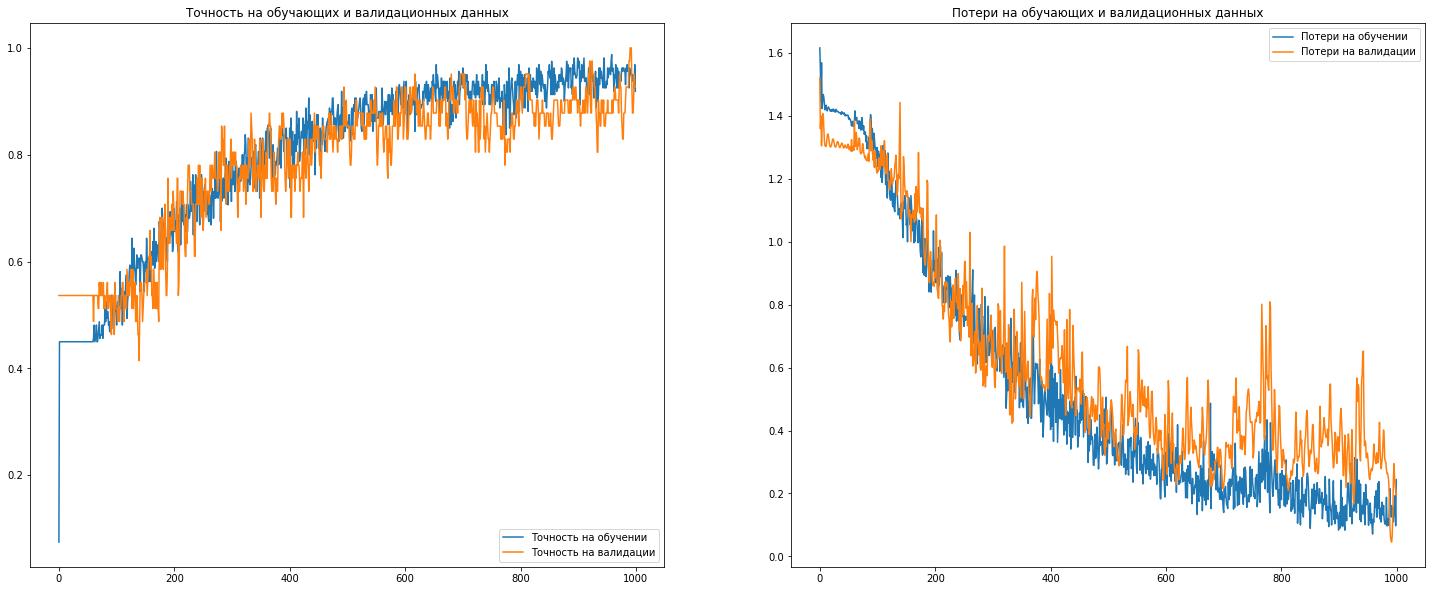

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1000)

plt.figure(figsize=(25,10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Точность на обучении')
plt.plot(epochs_range, val_acc, label='Точность на валидации')
plt.legend(loc='lower right')
plt.title('Точность на обучающих и валидационных данных')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Потери на обучении')
plt.plot(epochs_range, val_loss, label='Потери на валидации')
plt.legend(loc='upper right')
plt.title('Потери на обучающих и валидационных данных')
plt.savefig('./foo.png')
plt.show()

### Выведем оценку результатов:

In [ ]:
from sklearn.metrics import classification_report

y_pred=model.predict(X_test)
target_pred=np.argmax(y_pred, axis=1)
target_test=np.argmax(y_test, axis=1)
print(classification_report(target_test, target_pred))

              precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       1.00      1.00      1.00         5
           2       0.96      1.00      0.98        22
           3       0.50      0.50      0.50         2
           4       0.75      0.75      0.75         4

    accuracy                           0.93        41
   macro avg       0.84      0.82      0.83        41
weighted avg       0.93      0.93      0.93        41



## В целом, получили неплохой результат. Модель уверенно распознала и с высокой долей точности идентифицировала все классы.

### Посмотрим на предсказания, которые сделала модель:

In [ ]:
from matplotlib import pyplot as plt

def plot_gallery(images, titles, h, w, n_row=1, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i+1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

(4, 62, 47, 1)
(4, 2914)


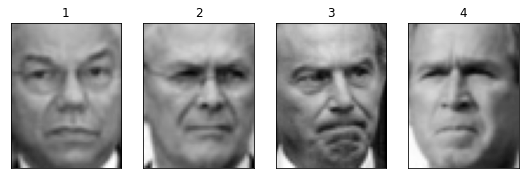

In [ ]:
test1=test[4:8].reshape(4,62*47)
plot_gallery(test1,'1234',62,47)
print(test[0:4].shape)
print(test1.shape)

In [ ]:
prediction_image=test[4:8]
prediction=model.predict(prediction_image)

for i in range(4):
    value=np.argmax(prediction[i])
    name=mapper(value)
    print("Prediction {} is {}.".format(i+1,name))

Prediction 1 is Colin Powell.
Prediction 2 is Donald Rumsfeld.
Prediction 3 is Tony Blair.
Prediction 4 is George W Bush.


#### В процессе работы сеть либо быстро переобучалась, либо не сходилась. Были испробованы все типы оптимизаторов с различными параметрами и dropout на скрытых и видимых слоях. Приемлемый результат удалось получить после сделанной аугментации (с "умеренными" параметрами) и ручным подбором количества эпох на оптимизаторе Adam (с параметрами по умолчанию). Возможный вариант решения этой проблемы вижу в применении переменной скорости обучения - например, каждый блок из 100 эпох начинать с высокой скорости и к 100-й эпохе делать скорость минимальной. Затем следующий блок из 100 эпох снова начинать с высоко скорости, постепенно снижая ее к концу блока. Полагаю, это поможет алгоритму преодолеть локальные минимумы. Постепенное снижение скорости обучения, если алгоритм в течении 20-30 эпох подряд не изменял accuracy и loss в нужную сторону сколь нибудь значимого эффекта не давало.   

## Задание 2.

В области компьютерного зрения, сверточная нейронная сеть (CNN) стала наиболее распространенным методом, на что указывает появление в последнее время GoogLenet, VGG-19, Incepetion и других моделей. Важным событием в развитии сверточных сетей стало появление ResNet. Эта конфигурация позволила обучать более глубокие нейронные сети, что значительно повысило их точность. Основная проблема глубоких сетей заключалась в том, что сначала при увеличении слоев точность увеличивалась, а затем резко падала. Чтобы обойти эту проблему в ResNet часть информации одного слоя через так называемые (shortcut connections) или соединения быстрого доступа передается на выход другого слоя. При этом информацию можно передать как на вход следующего слоя, так и пропустить один или несколько слоев. Это позволило бороться как с затуханием, так и со взрывом ингредиента.   

Следующим шаогом в этом направлении стало появление DenseNet, в основе которой лежит та же идея, что и у ResNet, но устанавливаются плотные связи между всеми передними слоями и задними слоями. Еще одной важной особенностью DenseNet является реализация повторного использования функций через соединение функций на канале. Этот метод позволяет добиться более высокой производительности, чем ResNet, с меньшими параметрами и вычислительными затратами.
По сравнению с ResNet, DenseNet предлагает более радикальный механизм плотного соединения: все слои связаны друг с другом, в частности, каждый уровень принимает все предыдущие уровни в качестве своего дополнительного входа. Кроме того, DenseNet напрямую объединяет карты функций из разных уровней, что позволяет реализовать повторное использование функций и повысить эффективность. Эта функция является основным отличием между DenseNet и ResNet. Стоит отметить еще один момент: в отличие от ResNet, все слои в DenseBlock выводятся после свертки. Это называется скоростью роста и является гиперпараметром.

В целом преимущества DenseNet в основном отражаются в следующих аспектах:

1. Благодаря методу плотного соединения, DenseNet улучшает обратное распространение градиента, облегчая обучение сети.
2. Параметры меньше, а вычисления более эффективны, за счет реализации межслойного соединения с помощью конкатных функций, обеспечивающих повторное использование функций.
3. Из-за мультиплексирования объектов в окончательном классификаторе используются низкоуровневые функции.

К недостаткам стоит отнести потребление большого количества памяти графического процессора при неправильной реализации сети. Это требует более тщательно подходить к выбору параметров входных слоев и количеству ядер свертки в зависимости от типов данных.